# environment setup:
- 현재 경로에 axial_MRI 폴더와 ipynb 파일을 위치


# axial MRI brain tumor detection

In [1]:
# package import

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

# Dataset 

In [2]:
print(f"axial_train: {len(os.listdir('axial_MRI/train')) - 1}")
print(f"axial_test: {len(os.listdir('axial_MRI/test')) - 1}")

axial_train: 332
axial_test: 39


In [3]:
PATH = "axial_MRI/train"
bbox = pd.read_csv(os.path.join(PATH, "_annotations.csv"))
bbox.head()

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,00254_83_jpg.rf.dc8444a939bfda955ec3a0ef668b5c...,192,256,positive,50,105,77,143
1,1,00305_113_jpg.rf.da8b7d0769c01e94571b568186f33...,256,256,positive,150,91,167,106
2,2,00097_80_jpg.rf.e31f89dee132f5da82d5e3c3fc0125...,256,256,negative,160,151,192,186
3,3,00099_154_jpg.rf.d9eb261c8c610b762f46f1e6f7cfc...,256,256,negative,90,187,107,205
4,4,00240_134_jpg.rf.dacd6bdae9ee803c1eed41507c352...,192,256,positive,85,97,106,126


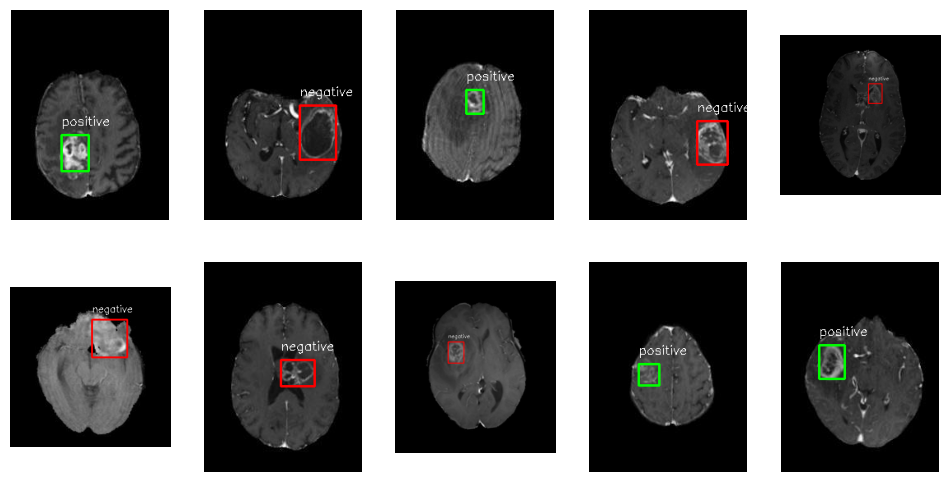

In [4]:
# 데이터셋 시각화
import random

figure = plt.figure(figsize=(12, 6)) 

row, col = 2, 5

r = random.randint(1, len(bbox))

for i in range(10):
    r = random.randint(1, len(bbox))
    value = bbox.values[r]
    img_name = value[1]
    color = (0, 255, 0) if value[4] == 'positive' else (255, 0, 0)
    txt = 'positive' if value[4] == 'positive' else 'negative'
    box = value[5:].astype('int')
    img = cv2.imread(os.path.join(PATH, img_name))
    pt1 = box[0], box[1]
    pt2 = box[2], box[3]
    cv2.rectangle(img, pt1, pt2, color, 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size, _ = cv2.getTextSize(txt, font, font_scale, thickness)
    x, y = pt1
    text_x = x
    text_y = y - text_size[1]
    cv2.putText(img, txt, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)
    figure.add_subplot(row, col, i+1)
    plt.axis("off")
    plt.imshow(img)

# Selective Search

In [5]:
# 아래의 Module 'cv2.cv2' has no attribute 'ximgproc' 가 뜬다면
# https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc 참고
# 패키지 재설치 후 커널 재시작 필요

num_regional proposal: 86


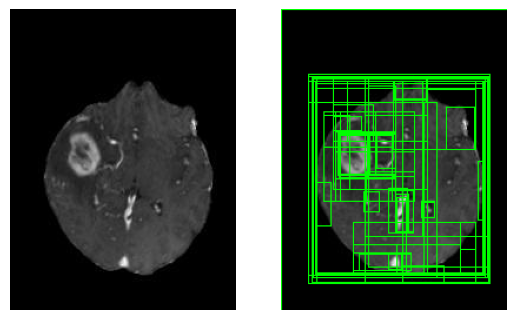

In [6]:
#Selective Search 알고리즘을 사용해 이미지 내의 객체 주변에 사각형 경계 상자 생성
img = cv2.imread(f'axial_MRI/train/{bbox.values[0][1]}')

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
ss.setBaseImage(img) 
ss.switchToSelectiveSearchFast() 
rects = ss.process()

for rect in rects:
    x, y, w, h = rect
    img_out = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_out)
print(f'num_regional proposal: {len(rects)}')

## Q1: get_iou 함수 구현

In [7]:
def get_iou(bb1, bb2):

    # input: x1, y1, x2, y2 를 가진 두 개의 dict  (x1, y1) : bbox 왼쪽 하단, (x2, y2) : bbox 우측 상단
    # return: float IoU value

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0

    intersection_area =  None ########## [your code] ##########
    bb1_area =  None  ########## [your code] ##########
    bb2_area =  None  ########## [your code] ##########
    iou =  None  ########## [your code] ##########
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Q1: test, 정상적으로 실행되면 정답

In [8]:
# unit test 

x, y, w, h = rects[0]
proposal_bbox = {'x1': x,
                 'y1': y,
                 'x2': x+w,
                 'y2': y+h} 

gtbox = bbox.values[0][5:].astype('int')
gtbb = {
        'x1': gtbox[0],
        'y1': gtbox[1],
        'x2': gtbox[2],
        'y2': gtbox[3]}

assert get_iou(gtbb, proposal_bbox) > 0.040 
assert get_iou(gtbb, proposal_bbox) < 0.042, "error get_iou"

## Q2: Selective Search 함수 구현

In [9]:
#iou_threshold를 기준으로 positive_sample과 negative_sample을 분류하는 selective_search_ 함수 구현

def selective_search_(ss, img, gtbb, iou_threshold):

    positive_sample = []
    negative_sample = []

    up_threshold, down_threshold = iou_threshold

    ss.setBaseImage(img) 
    ss.switchToSelectiveSearchFast() 
    rects = ss.process()

    for rect in rects:
        x, y, w, h = rect
        bb2 = {'x1': x,
               'y1': y,
               'x2': x+w,
               'y2': y+h} 
        iou = None #### [your code] #### get_iou 호출
        img_croped=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']]
        img_resized = None #### [yout code] #### (224, 224) 로 resize (cv2 사용)

        if iou >= up_threshold:
            positive_sample.append(img_resized)
        
        elif iou <= down_threshold:
            negative_sample.append(img_resized)

    return positive_sample, negative_sample

## Q2: Test, 아래 코드가 실행되면 정답

In [10]:
# selective_search_함수를 이용하여 분류한 positive_sample과 negative_sample 수 확인

cv2.setUseOptimized(True) 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 

up_threshold = 0.5
down_threshold = 0.1

threshold = (up_threshold, down_threshold)
positive_sample = []
negative_sample = []

for value in bbox.values:
    name = value[1]
    img = cv2.imread(os.path.join(PATH, name))
    gtbox = value[5:].astype('int')
    gtbb = {
            'x1': gtbox[0],
            'y1': gtbox[1],
            'x2': gtbox[2],
            'y2': gtbox[3]
           }
    pos, neg = selective_search_(ss, img, gtbb, threshold)
    positive_sample += pos
    negative_sample += neg


len(positive_sample), len(negative_sample)

(2040, 29995)

In [11]:
#negative_sample 수와 positive_sample 수 통일

negative_sample = negative_sample[:len(positive_sample)]

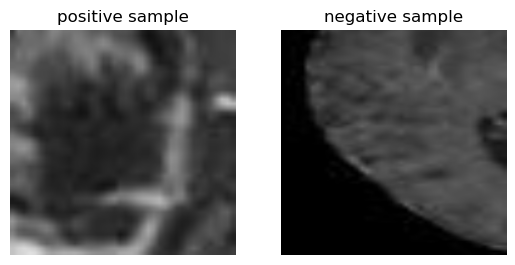

In [12]:
#positive_sample과 negative_sample 시각화

import random

r1 = random.randint(1, len(positive_sample) + 1)
r2 = random.randint(1, len(negative_sample) + 1)

plt.subplot(1, 2, 1)
plt.imshow(positive_sample[r1])
plt.axis('off')
plt.title('positive sample')

plt.subplot(1, 2, 2)
plt.imshow(negative_sample[r2])
plt.axis('off')
plt.title('negative sample')
plt.show()

In [13]:
#실제 양성/음성 종양 여부에 따른 리스트 생성

positive_tumor = []
negative_tumor = []

for elem in bbox.values:
    name = elem[1]
    img = cv2.imread(os.path.join(PATH, name))
    box = elem[5:].astype('int')
    cr_img = img[box[1]:box[3], box[0]:box[2]]
    re_img = cv2.resize(cr_img, (224, 224))
    if elem[4] == 'positive':
        positive_tumor.append(re_img)
    else:
        negative_tumor.append(re_img)

# model

### ROI

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

#이미지를 텐서로 변환하고 데이터 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
    ])

#양성 및 음성 종양 샘플을 입력으로 받아 데이터셋 구성
class ROIDataset(Dataset): 
    def __init__(self, positive_sample, negative_sample):
        self.datas = np.array(positive_sample + negative_sample)
        self.labels = np.array([1 for i in range(len(positive_sample))] + [0 for i in range(len(negative_sample))])
        self.transform = transform
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        data = self.transform(self.datas[idx])
        label = torch.tensor(self.labels[idx])
        return data, label
    
class TumorDataset(Dataset):
    def __init__(self, positive_tumor, negative_tumor):
        self.datas = positive_tumor + negative_tumor
        self.labels = [1 for i in range(len(positive_tumor))] + [0 for i in range(len(negative_tumor))]
        self.transform = transform
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        data = self.transform(self.datas[idx])
        label = torch.tensor(self.labels[idx])
        return data, label

In [15]:
#생성한 데이터셋을 저장
ROIData = ROIDataset(positive_sample, negative_sample)
TumorData = TumorDataset(positive_tumor, negative_tumor)
torch.save(ROIData, "roi.pt")
torch.save(TumorData, "tumor.pt")

In [16]:
#저장한 데이터셋을 불러옴
ROIData = torch.load('roi.pt')
TumorData = torch.load('tumor.pt')

In [17]:
#ROIData에 대한 객체 탐지 모델 정의. 합성곱 신경망 
class ROINet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

#모델의 순전파 정의
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = x.view(-1, 64 * 56 * 56)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

dataset = ROIData
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


ROImodel = ROINet()
ROIcriterion = nn.BCELoss()
ROIoptimizer = optim.Adam(ROImodel.parameters(), lr=0.001)

#모델 학습
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for img, label in dataloader:
        image = img
        label = label
        ROIoptimizer.zero_grad()
        outputs = ROImodel(image)
        loss = ROIcriterion(outputs, label.float().view(-1, 1))
        loss.backward()
        ROIoptimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

Epoch 1, Loss: 2.1968807140365243


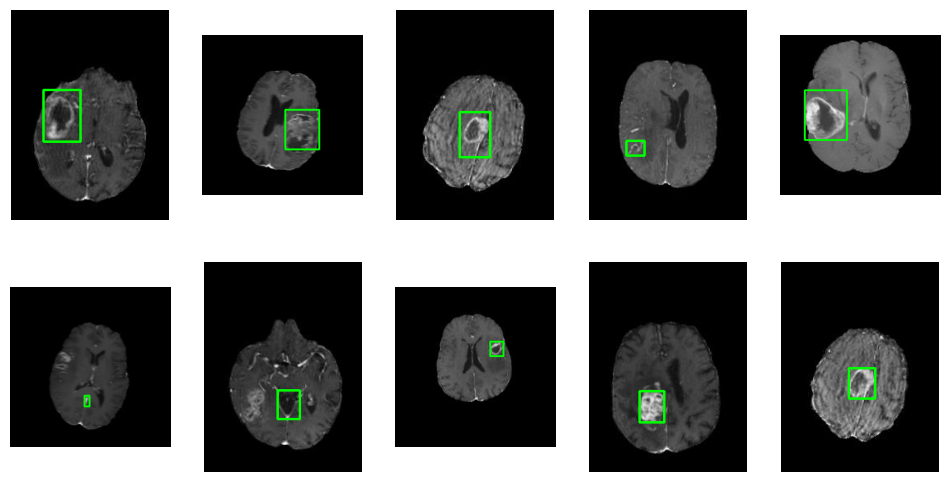

In [18]:
#이미지에서 객체 탐지 및 시각화
ROImodel.eval()

figure = plt.figure(figsize=(12, 6)) 

row, col = 2, 5

r = random.randint(1, len(bbox))

for i in range(10):
    r = random.randint(1, len(bbox))
    value = bbox.values[r]
    img_name = value[1]
    img = cv2.imread(os.path.join(PATH, img_name))
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
    ss.setBaseImage(img) 
    ss.switchToSelectiveSearchFast() 
    rects = ss.process()
    
    roimg = []
    rois = []
    for rect in rects:
        x, y, w, h = rect
        bb = {'x1': x,
               'y1': y,
               'x2': x+w,
               'y2': y+h} 
        img_croped=img[bb['y1']:bb['y2'],bb['x1']:bb['x2']]
        img_resized = cv2.resize(img_croped, (224, 224))
        roimg.append(img_resized)
        rois.append(bb)

    with torch.no_grad():
        transformed_data_list = [transform(data) for data in roimg]
        batch = torch.stack(transformed_data_list)
        output1 = ROImodel(batch)
        idx = output1.argmax()

    roi = rois[idx]
    pt1 = (roi['x1'], roi['y1'])
    pt2 = (roi['x2'], roi['y2'])
    cv2.rectangle(img, pt1, pt2, color, 2)
    figure.add_subplot(row, col, i+1)
    plt.axis("off")
    plt.imshow(img)

In [19]:
#모델의 학습된 가중치 저장
torch.save(ROImodel.state_dict(), 'ROImodel.pt')

### Tumor

In [20]:
#TumorData에 대한 객체 탐지 모델 정의. 합성곱 신경망 
class TumorNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(24)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(24 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 24 * 56 * 56)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x


dataset = TumorData
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


Tumormodel = TumorNet()
Tumorcriterion = nn.BCELoss()
Tumoroptimizer = optim.Adam(Tumormodel.parameters(), lr=0.001)

#모델 학습
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for img, label in dataloader:
        image = img
        label = label
        Tumoroptimizer.zero_grad()
        outputs = Tumormodel(image)
        loss = Tumorcriterion(outputs, label.float().view(-1, 1))
        loss.backward()
        Tumoroptimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

Epoch 1, Loss: 20.656442840894062


In [21]:
#테스트 데이터에 대한 객체 탐지 수행 및 모델 성능 평가
bbox_test = pd.read_csv('axial_MRI/test/_annotations.csv')

path = 'axial_MRI/test/'

Tumormodel.eval()

TumorNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=75264, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

# result

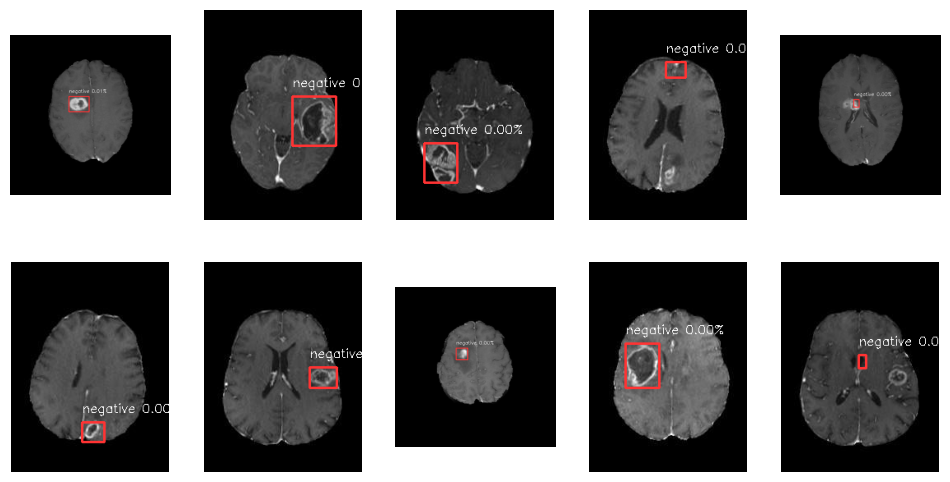

In [22]:
#최종 객체 탐지와 양성 및 음성 예측 결과 시각화
def inference(img, ss, models, transform):
    ss.setBaseImage(img) 
    ss.switchToSelectiveSearchFast() 
    rects = ss.process()
    
    ROIs = []
    bboxs = []
    
    for rect in rects:
        x, y, w, h = rect
        bb = {'x1': x,
              'y1': y,
              'x2': x+w,
              'y2': y+h} 
        img_croped=img[bb['y1']:bb['y2'],bb['x1']:bb['x2']]
        img_resized = cv2.resize(img_croped, (224, 224))
        bboxs.append(bb)
        ROIs.append(img_resized)
    
    ROImodel, Tumormodel = models

    assert ROImodel.training == False
    assert Tumormodel.training == False
    
    with torch.no_grad():
        transformed_data_list = [transform(data) for data in ROIs]
        batch = torch.stack(transformed_data_list)
        output1 = ROImodel(batch)
        idx = output1.argmax()
        ROI = ROIs[idx]
        ROI = transform(ROI)
        input_ = ROI.unsqueeze(0)
        acc = Tumormodel(input_).item() * 100

        if acc >= 50:
            color = (51, 255, 153)
            txt = f'positive {acc:.2f}%'
        else:
            color = (255, 51 ,51)
            txt = f'negative {acc:.2f}%'
        color = (51, 255, 153) if acc >= 50 else (255, 51, 51)
        pt1 = (bboxs[idx]['x1'], bboxs[idx]['y1'])
        pt2 = (bboxs[idx]['x2'], bboxs[idx]['y2'])
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        thickness = 1
        cv2.rectangle(img, pt1, pt2, color, 2)
        text_size, _ = cv2.getTextSize(txt, font, font_scale, thickness)
        x, y = pt1
        text_x = x
        text_y = y - text_size[1]
        cv2.putText(img, txt, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

    return img

figure = plt.figure(figsize=(12, 6))
row, col = 2, 5

for i in range(10):
    r = random.randint(1, 37)
    value = bbox_test.values[r]
    img_name = value[0]
    img = cv2.imread(os.path.join(path, img_name))
    img_ = inference(img, ss, (ROImodel, Tumormodel), transform)
    figure.add_subplot(row, col, i+1)
    plt.axis('off')
    plt.imshow(img_)